In [1]:
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [3]:
def gen_block(x, filters = 128, kernel_size = 5, strides = 2, padding = "same"):
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
    return x

In [4]:
def build_generator(inputs, image_size):
  image_resize = image_size // 4
  x = Dense(image_resize * image_resize * 128)(inputs)
  x = Reshape((image_resize, image_resize, 128))(x)
  x = gen_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
  x = gen_block(x = x, filters = 32, kernel_size = 5, strides = 1, padding = "same")
  x = gen_block(x = x, filters = 1, kernel_size = 5, strides = 1, padding = "same")
  x = Activation('sigmoid')(x)
  generator = Model(inputs, x, name = "generator")
  return generator

In [5]:
def disc_block(x, filters = 64, kernel_size = 5, strides = 2, padding = "same"):
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
  return x

In [6]:
def build_discriminator(inputs):
   x = inputs    # no BN after this as suggested in original paper
   x = LeakyReLU(alpha = 0.2)(x)
   x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = "same")(x)
   x = disc_block(x = x, filters = 64, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 128, kernel_size = 5, strides = 2, padding = "same")
   x = disc_block(x = x, filters = 256, kernel_size = 5, strides = 1, padding = "same")
   x = Flatten()(x)
   x = Dense(1)(x)
   x = Activation("sigmoid")(x)      # not tanh for mnist but used in original paper for other datasets
   discriminator = Model(inputs, x, name = 'discriminator')
   return discriminator

In [7]:
(x_train, _), (_ , _) = mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

latent_size = 100 # latent vector of 100-dim
batch_size = 64
input_shape = (image_size, image_size, 1)


# discriminator model
inputs = Input(shape = input_shape, name = "discriminator_input")
discriminator = build_discriminator(inputs)
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5),
                      metrics = ['accuracy'])
discriminator.summary()

11490434/11490434 [==============================] - 2s 0us/step
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                      

In [8]:
# generator model
input_shape = (latent_size,)
inputs = Input(shape = input_shape, name = 'generator_input')
generator = build_generator(inputs, image_size)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       40

In [9]:
# adversarial model
discriminator.trainable = False
adversarial = Model(inputs, discriminator(generator(inputs)), name = "dcgan_mnist")
adversarial.compile(loss = "binary_crossentropy",
                    optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5),
                    metrics = ['accuracy'])
adversarial.summary()

Model: "dcgan_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 generator (Functional)      (None, 28, 28, 1)         1301505   
                                                                 
 discriminator (Functional)  (None, 1)                 1081473   
                                                                 
Total params: 2382978 (9.09 MB)
Trainable params: 1300801 (4.96 MB)
Non-trainable params: 1082177 (4.13 MB)
_________________________________________________________________


In [10]:
train_steps = 5000
def train(models, x_train, params):

  generator, discriminator, adversarial = models
  batch_size, latent_size, train_steps, model_name = params
  save_interval = 500

  noise_input = np.random.uniform(-1.0, 1.0, size = [16, latent_size])
  train_size = x_train.shape[0]

  for i in range(train_steps):
    rand_indexes = np.random.randint(0, train_size, size = batch_size)
    real_images = x_train[rand_indexes]
    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    fake_images = generator.predict(noise)

    x = np.concatenate((real_images, fake_images))
    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0.0

    loss, acc = discriminator.train_on_batch(x, y)
    log = f"{i}: [Discriminator Loss: {loss}, acc: {acc}]"
    print(log)

    noise = np.random.uniform(-1.0, 1.0, size = [batch_size, latent_size])
    y = np.ones([batch_size, 1])
    loss, acc = adversarial.train_on_batch(noise, y)
    log = f"{i}: [Adversarial Loss: {loss}, acc: {acc}]"
    print(log)


    if (i + 1) % save_interval == 0:
      os.makedirs("dcgan_mnist", exist_ok=True)
      filename = os.path.join("dcgan_mnist", f"{i + 1:05d}.png")
      images = generator.predict(noise_input)
      plt.figure(figsize=(2.2, 2.2))
      num_images = images.shape[0]
      image_size = images.shape[1]
      rows = int(math.sqrt(noise_input.shape[0]))
      for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
      plt.savefig(filename)
      plt.show()

  generator.save("dcgan_mtnis" + ".h5")

2/2 [==============================] - 3s 6ms/step
0: [Discriminator Loss: 0.6778038144111633, acc: 0.7734375]
0: [Adversarial Loss: 0.7357494235038757, acc: 0.0]
2/2 [==============================] - 0s 5ms/step
1: [Discriminator Loss: 0.02867535874247551, acc: 1.0]
1: [Adversarial Loss: 0.759342610836029, acc: 0.0]
2/2 [==============================] - 0s 4ms/step
2: [Discriminator Loss: 0.0037941387854516506, acc: 1.0]
2: [Adversarial Loss: 0.7672198414802551, acc: 0.0]
2/2 [==============================] - 0s 4ms/step
3: [Discriminator Loss: 0.0012293390464037657, acc: 1.0]
3: [Adversarial Loss: 0.7703405618667603, acc: 0.0]
2/2 [==============================] - 0s 4ms/step
4: [Discriminator Loss: 0.0007082417141646147, acc: 1.0]
4: [Adversarial Loss: 0.7705826759338379, acc: 0.0]
2/2 [==============================] - 0s 5ms/step
5: [Discriminator Loss: 0.0005179456784389913, acc: 1.0]
5: [Adversarial Loss: 0.7693074941635132, acc: 0.0]
2/2 [==============================] - 0

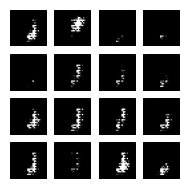

2/2 [==============================] - 0s 7ms/step
500: [Discriminator Loss: 0.025511814281344414, acc: 0.984375]
500: [Adversarial Loss: 0.1303449273109436, acc: 0.96875]
2/2 [==============================] - 0s 5ms/step
501: [Discriminator Loss: 0.023412348702549934, acc: 0.9921875]
501: [Adversarial Loss: 0.1250399351119995, acc: 1.0]
2/2 [==============================] - 0s 4ms/step
502: [Discriminator Loss: 0.017774036154150963, acc: 0.984375]
502: [Adversarial Loss: 0.2646077871322632, acc: 0.90625]
2/2 [==============================] - 0s 6ms/step
503: [Discriminator Loss: 0.07588711380958557, acc: 0.9609375]
503: [Adversarial Loss: 0.16908912360668182, acc: 0.9375]
2/2 [==============================] - 0s 6ms/step
504: [Discriminator Loss: 0.02201911248266697, acc: 0.984375]
504: [Adversarial Loss: 0.29003334045410156, acc: 0.875]
2/2 [==============================] - 0s 5ms/step
505: [Discriminator Loss: 0.006154348142445087, acc: 1.0]
505: [Adversarial Loss: 0.3997503519

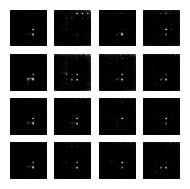

2/2 [==============================] - 0s 5ms/step
1000: [Discriminator Loss: 0.0004815005522686988, acc: 1.0]
1000: [Adversarial Loss: 0.04588225483894348, acc: 1.0]
2/2 [==============================] - 0s 7ms/step
1001: [Discriminator Loss: 0.0005588560597971082, acc: 1.0]
1001: [Adversarial Loss: 0.05221360921859741, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1002: [Discriminator Loss: 0.000293615332338959, acc: 1.0]
1002: [Adversarial Loss: 0.05595461651682854, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1003: [Discriminator Loss: 0.00026941834948956966, acc: 1.0]
1003: [Adversarial Loss: 0.05674086511135101, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1004: [Discriminator Loss: 0.00023401605722028762, acc: 1.0]
1004: [Adversarial Loss: 0.05981176346540451, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1005: [Discriminator Loss: 0.0006390244816429913, acc: 1.0]
1005: [Adversarial Loss: 0.06257370859384537, acc: 1.

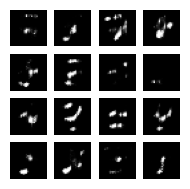

2/2 [==============================] - 0s 4ms/step
1500: [Discriminator Loss: 0.03911684826016426, acc: 0.984375]
1500: [Adversarial Loss: 0.10369709879159927, acc: 0.953125]
2/2 [==============================] - 0s 5ms/step
1501: [Discriminator Loss: 0.09348339587450027, acc: 0.96875]
1501: [Adversarial Loss: 0.1011013463139534, acc: 0.953125]
2/2 [==============================] - 0s 6ms/step
1502: [Discriminator Loss: 0.028768517076969147, acc: 0.984375]
1502: [Adversarial Loss: 0.06272253394126892, acc: 0.984375]
2/2 [==============================] - 0s 6ms/step
1503: [Discriminator Loss: 0.018496453762054443, acc: 1.0]
1503: [Adversarial Loss: 0.03192432224750519, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1504: [Discriminator Loss: 0.0245310440659523, acc: 1.0]
1504: [Adversarial Loss: 0.012576029635965824, acc: 1.0]
2/2 [==============================] - 0s 5ms/step
1505: [Discriminator Loss: 0.045601632446050644, acc: 0.984375]
1505: [Adversarial Loss: 0.026

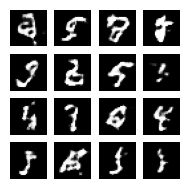

2/2 [==============================] - 0s 5ms/step
2000: [Discriminator Loss: 0.513327956199646, acc: 0.78125]
2000: [Adversarial Loss: 1.924457311630249, acc: 0.0625]
2/2 [==============================] - 0s 5ms/step
2001: [Discriminator Loss: 0.5334963798522949, acc: 0.7421875]
2001: [Adversarial Loss: 3.9559221267700195, acc: 0.0]
2/2 [==============================] - 0s 5ms/step
2002: [Discriminator Loss: 0.39002159237861633, acc: 0.8203125]
2002: [Adversarial Loss: 3.0737457275390625, acc: 0.015625]
2/2 [==============================] - 0s 5ms/step
2003: [Discriminator Loss: 0.39631468057632446, acc: 0.796875]
2003: [Adversarial Loss: 3.4777748584747314, acc: 0.0625]
2/2 [==============================] - 0s 5ms/step
2004: [Discriminator Loss: 0.378958135843277, acc: 0.8359375]
2004: [Adversarial Loss: 1.9125896692276, acc: 0.125]
2/2 [==============================] - 0s 5ms/step
2005: [Discriminator Loss: 0.4585542380809784, acc: 0.78125]
2005: [Adversarial Loss: 3.7058205604

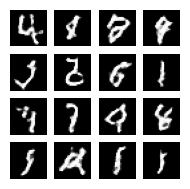

2/2 [==============================] - 0s 5ms/step
2500: [Discriminator Loss: 0.4566020369529724, acc: 0.75]
2500: [Adversarial Loss: 1.3166773319244385, acc: 0.21875]
2/2 [==============================] - 0s 5ms/step
2501: [Discriminator Loss: 0.4530399739742279, acc: 0.78125]
2501: [Adversarial Loss: 0.7458111047744751, acc: 0.640625]
2/2 [==============================] - 0s 5ms/step
2502: [Discriminator Loss: 0.47136521339416504, acc: 0.78125]
2502: [Adversarial Loss: 1.6620174646377563, acc: 0.21875]
2/2 [==============================] - 0s 5ms/step
2503: [Discriminator Loss: 0.36530375480651855, acc: 0.84375]
2503: [Adversarial Loss: 1.3857522010803223, acc: 0.234375]
2/2 [==============================] - 0s 5ms/step
2504: [Discriminator Loss: 0.3876321315765381, acc: 0.84375]
2504: [Adversarial Loss: 0.7622073888778687, acc: 0.515625]
2/2 [==============================] - 0s 5ms/step
2505: [Discriminator Loss: 0.47763827443122864, acc: 0.7421875]
2505: [Adversarial Loss: 1.6

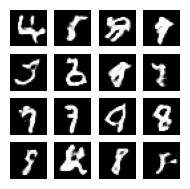

2/2 [==============================] - 0s 5ms/step
3000: [Discriminator Loss: 0.43698447942733765, acc: 0.796875]
3000: [Adversarial Loss: 2.294739246368408, acc: 0.109375]
2/2 [==============================] - 0s 5ms/step
3001: [Discriminator Loss: 0.5450360774993896, acc: 0.7734375]
3001: [Adversarial Loss: 1.8170182704925537, acc: 0.125]
2/2 [==============================] - 0s 5ms/step
3002: [Discriminator Loss: 0.5548655390739441, acc: 0.7109375]
3002: [Adversarial Loss: 1.8993141651153564, acc: 0.140625]
2/2 [==============================] - 0s 5ms/step
3003: [Discriminator Loss: 0.46762704849243164, acc: 0.7421875]
3003: [Adversarial Loss: 1.8585097789764404, acc: 0.078125]
2/2 [==============================] - 0s 5ms/step
3004: [Discriminator Loss: 0.39623889327049255, acc: 0.8125]
3004: [Adversarial Loss: 2.132171630859375, acc: 0.09375]
2/2 [==============================] - 0s 5ms/step
3005: [Discriminator Loss: 0.4832644462585449, acc: 0.796875]
3005: [Adversarial Loss:

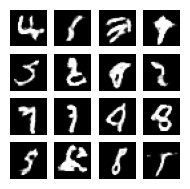

2/2 [==============================] - 0s 5ms/step
3500: [Discriminator Loss: 0.4248237609863281, acc: 0.8203125]
3500: [Adversarial Loss: 2.231757640838623, acc: 0.015625]
2/2 [==============================] - 0s 5ms/step
3501: [Discriminator Loss: 0.5001130104064941, acc: 0.7578125]
3501: [Adversarial Loss: 1.550788402557373, acc: 0.140625]
2/2 [==============================] - 0s 5ms/step
3502: [Discriminator Loss: 0.42341524362564087, acc: 0.8046875]
3502: [Adversarial Loss: 2.081590414047241, acc: 0.09375]
2/2 [==============================] - 0s 8ms/step
3503: [Discriminator Loss: 0.45622625946998596, acc: 0.765625]
3503: [Adversarial Loss: 2.0187456607818604, acc: 0.046875]
2/2 [==============================] - 0s 5ms/step
3504: [Discriminator Loss: 0.5518085360527039, acc: 0.734375]
3504: [Adversarial Loss: 1.251052975654602, acc: 0.328125]
2/2 [==============================] - 0s 5ms/step
3505: [Discriminator Loss: 0.5481475591659546, acc: 0.7265625]
3505: [Adversarial Lo

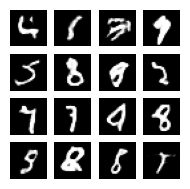

2/2 [==============================] - 0s 5ms/step
4000: [Discriminator Loss: 0.5102956295013428, acc: 0.7734375]
4000: [Adversarial Loss: 1.2242822647094727, acc: 0.1875]
2/2 [==============================] - 0s 5ms/step
4001: [Discriminator Loss: 0.5156474113464355, acc: 0.75]
4001: [Adversarial Loss: 1.4723848104476929, acc: 0.171875]
2/2 [==============================] - 0s 5ms/step
4002: [Discriminator Loss: 0.5306921005249023, acc: 0.734375]
4002: [Adversarial Loss: 0.8400601148605347, acc: 0.46875]
2/2 [==============================] - 0s 6ms/step
4003: [Discriminator Loss: 0.5767506957054138, acc: 0.6875]
4003: [Adversarial Loss: 0.6985375285148621, acc: 0.5625]
2/2 [==============================] - 0s 5ms/step
4004: [Discriminator Loss: 0.47109800577163696, acc: 0.765625]
4004: [Adversarial Loss: 1.0756616592407227, acc: 0.359375]
2/2 [==============================] - 0s 5ms/step
4005: [Discriminator Loss: 0.48625385761260986, acc: 0.8046875]
4005: [Adversarial Loss: 0.96

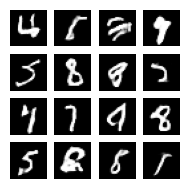

2/2 [==============================] - 0s 5ms/step
4500: [Discriminator Loss: 0.5239737629890442, acc: 0.765625]
4500: [Adversarial Loss: 1.3265748023986816, acc: 0.265625]
2/2 [==============================] - 0s 5ms/step
4501: [Discriminator Loss: 0.6157516241073608, acc: 0.6640625]
4501: [Adversarial Loss: 2.0222089290618896, acc: 0.078125]
2/2 [==============================] - 0s 5ms/step
4502: [Discriminator Loss: 0.5283926725387573, acc: 0.734375]
4502: [Adversarial Loss: 2.135000467300415, acc: 0.046875]
2/2 [==============================] - 0s 5ms/step
4503: [Discriminator Loss: 0.48720017075538635, acc: 0.7578125]
4503: [Adversarial Loss: 2.344252586364746, acc: 0.015625]
2/2 [==============================] - 0s 6ms/step
4504: [Discriminator Loss: 0.519679069519043, acc: 0.6875]
4504: [Adversarial Loss: 2.4904236793518066, acc: 0.015625]
2/2 [==============================] - 0s 5ms/step
4505: [Discriminator Loss: 0.523916482925415, acc: 0.7265625]
4505: [Adversarial Loss:

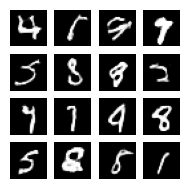

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, "dcgan_mtnis")
train(models, x_train, params)